In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip install tabula-py
# %pip install openpyxl 
# %pip install thefuzz

In [1]:
import shutil
import pandas as pd
import tabula
from thefuzz import process
import matplotlib.pyplot as plt

In [2]:
# # Unpack Enrollment data 

# filename = "./enrollment_2425.zip"
# extract_dir = "./"

# shutil.unpack_archive(filename, extract_dir, "zip")

# Load Data

### Public school data

In [5]:
NJPubSchool_path = "./Datasets/NJPubSchool.csv"

# 1) Find the line number where the real header starts (the one that begins with "County Code")
header_line_idx = None
with open(NJPubSchool_path, "r") as f:
    for i, line in enumerate(f):
        
        if line.strip().startswith("County Code"):
            
            header_line_idx = i
            break

if header_line_idx is None:
    raise RuntimeError("Couldn't find header row (starting with 'County Code,County Name').")

# 2) Skip rows that are not part of the tabel and load data into pandas dataframe
Public_sch_df = pd.read_csv(
    NJPubSchool_path, 
    skiprows=header_line_idx,
    )

# 3) Normalize cells:
#    - Strip whitespace
#    - Convert '="123"' -> '123'
#    - Turn a single-space placeholder (" ") into NA
def _clean_cell(x):
    if not isinstance(x, str):
        return x
    s = x.strip()
    # Excel text wrapper pattern: ="...". Remove if present.
    if s.startswith('="') and s.endswith('"'):
        s = s[2:-1]
    # Some rows use a lone space to mean blank
    if s == "":
        return pd.NA
    if s == '"':
        return pd.NA
    if s == " ":
        return pd.NA
    return s

Public_sch_df = Public_sch_df.map(_clean_cell)

# Optional: fix obvious misspelling in header (if present)
Public_sch_df = Public_sch_df.rename(columns=lambda c: c.replace("First Nname", "First Name") if isinstance(c, str) else c)



In [3]:
Public_sch_df.head()

,County Code,County Name,District Code,District Name,School Code,School Name,Princ. Title,Princ. First Name,Princ. Last Name,Princ. Title 2,...,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Post Grad,Adult Ed.,NCES Code
0,01,ATLANTIC,0010,Absecon Public Schools District,050,Emma C Attales,Mr.,Kevin,Burns,School Principal,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,00004
1,01,ATLANTIC,0010,Absecon Public Schools District,060,H Ashton Marsh,Ms.,Leslie,Schiavo,School Principal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00006
2,01,ATLANTIC,0110,Atlantic City School District,010,Atlantic City High School,Mrs.,Constance,Days -Chapman,School Principal,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,00010
3,01,ATLANTIC,0110,Atlantic City School District,300,Brighton Avenue School,Mr.,Jason,Grimes,School Principal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
4,01,ATLANTIC,0110,Atlantic City School District,050,Chelsea Heights School,Mr.,James,Knox,School Principal,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,00016


### Title_I_data

In [4]:
Title_I_list = tabula.read_pdf("./Datasets/newjerseypdf-40553.pdf", pages="all",pandas_options={"header": None},multiple_tables=True) 

list_len = len(Title_I_list)
for i in range(list_len):
    Title_I_list[i].columns = ["ID", "District", "Allocation"]

Title_I_df = pd.concat((Title_I_list[i] for i in range(list_len)), ignore_index=True)

In [82]:
Title_I_df

,ID,District,Allocation
0,3400660,ABSECON CITY,"90,622"
1,3400690,ALEXANDRIA TOWNSHIP,0
2,3400720,ALLAMUCHY TOWNSHIP,0
3,3400750,ALLENDALE BOROUGH,0
4,3400780,ALLENHURST,0
...,...,...,...
567,3418180,WOODBURY HEIGHTS BOROUGH,0
568,3418210,WOODCLIFF LAKE BOROUGH,0
569,3418240,WOODLAND TOWNSHIP,0
570,3418270,WOODLYNNE BOROUGH,"172,986"


### Enrollment data

In [3]:
Enroll_dict = pd.read_excel("./Datasets/enrollment_2425.xlsx", sheet_name=None)
Enroll_dict.pop("Introduction and changes")
for key in Enroll_dict.keys():
    new_header = Enroll_dict[key].iloc[1]   # row 2 becomes header
    Enroll_dict[key] = Enroll_dict[key][2:-1]   # keep everything after row 2
    Enroll_dict[key].columns = new_header

In [79]:
Enroll_dict["District"].columns
 

Index(['County Code', 'County Name', 'District Code', 'District Name',
       'Total Enrollment', 'White', '%White', 'Black', '%Black', 'Hispanic',
       '%Hispanic', 'Asian', '%Asian', 'Native American', '%Native American',
       'Hawaiian Native', '%Hawaiian Native', 'Two or More Races',
       '%Two or More Races', 'Pre-K Halfday', '%Pre-K Halfday',
       'Pre-K FullDay', '%Pre-K FullDay', 'Kindergarten Halfday',
       '%Kindergarten Halfday', 'Kindergarten Fullday',
       '%Kindergarten Fullday', 'First Grade', '%First Grade', 'Second Grade',
       '%Second Grade', 'Third Grade', '%Third Grade', 'Fourth Grade',
       '%Fourth Grade', 'Fifth Grade', '%Fifth Grade', 'Sixth Grade',
       '%Sixth Grade', 'Seventh Grade', '%Seventh Grade', 'Eighth Grade',
       '%Eighth Grade', 'Ninth Grade', '%Ninth Grade', 'Tenth Grade',
       '%Tenth Grade', 'Eleventh Grade', '%Eleventh Grade', 'Twelfth Grade',
       '%Twelfth Grade', 'Free Lunch ', '%Free Lunch', 'Reduced Lunch',
       '

In [77]:
Enroll_dict["District"].head()

1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,...,Multilingual Learners,%Multilingual Learners,Migrant,%Migrant,Military,%Military,Homeless,%Homeless,Column1,Column2
2,01,Atlantic,0010,Absecon Public Schools District,910,398,43.7,111,12.2,291,...,98,10.8,0,0,6,0.7,23,2.5,23,2.5
3,01,Atlantic,0110,Atlantic City School District,6410,159,2.5,2165,33.8,2957,...,1408,22,0,0,38,0.6,107,1.7,107,1.7
4,01,Atlantic,0125,Atlantic County Special Services School District,336,94,28,97,28.9,116,...,1,0.3,0,0,2,0.6,8,2.4,8,2.4
5,01,Atlantic,0120,Atlantic County Vocational School District,1852,549,29.6,272,14.7,784,...,0,0,0,0,20,1.1,18,1,18,1
6,01,Atlantic,0570,Brigantine Public School District,380,283,74.5,12,3.2,44,...,9,2.4,0,0,3,0.8,5,1.3,5,1.3


# Preprocessing

### Title I allocation

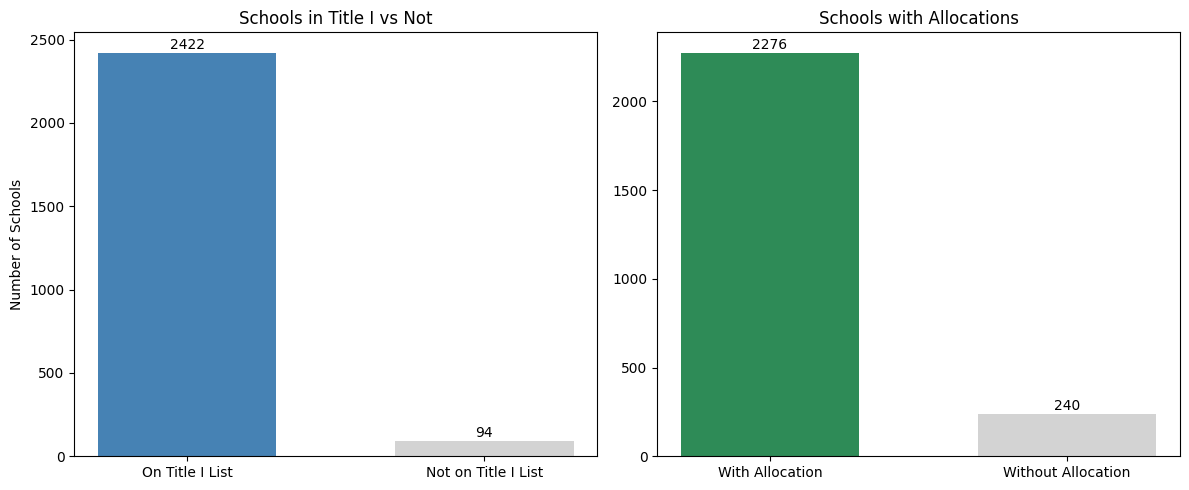

In [13]:
# -----------------------------
# 1. Keep only necessary columns
# -----------------------------
sch_df = Public_sch_df[
    ["County Code", "County Name", 
     "District Code", "District Name",
     "School Code", "School Name"]
].copy()

# -----------------------------
# 2. Clean Title I dataframe
# -----------------------------
# Normalize Allocation → integer
Title_I_df["Allocation"] = (
    Title_I_df["Allocation"]
    .copy()
    .str.replace(",", "", regex=False)
    .astype(int)
)

# Normalize District names
Title_I_df["District"] = Title_I_df["District"].str.strip().str.upper()
sch_df["District Name"] = sch_df["District Name"].str.strip().str.upper()

# -----------------------------
# 3. Build fuzzy district mapping
# -----------------------------
def build_mapping(source_districts, target_districts, threshold=85):
    mapping = {}
    for d in source_districts:
        match, score = process.extractOne(d, target_districts)
        if score >= threshold:
            mapping[d] = match
    return mapping

mapping_all = build_mapping(
    sch_df["District Name"].unique(),
    Title_I_df["District"].unique()
)

mapping_allocated = build_mapping(
    sch_df["District Name"].unique(),
    Title_I_df.loc[Title_I_df["Allocation"] > 0, "District"].unique()
)

# -----------------------------
# 4. Apply mapping
# -----------------------------
sch_df["District_mapped"] = sch_df["District Name"].map(mapping_all)
sch_df["District_allocated"] = sch_df["District Name"].map(mapping_allocated)

# -----------------------------
# 5. Create filtered datasets
# -----------------------------
title_i_schl_df = sch_df[sch_df["District_mapped"].notna()].copy()
title_i_schl_df_allocated = sch_df[sch_df["District_allocated"].notna()].copy()

# -----------------------------
# 6. Metrics
# -----------------------------
schools_on_title_I = len(title_i_schl_df)
schools_not_on_title_I = len(sch_df) - schools_on_title_I

schools_allocated = len(title_i_schl_df_allocated)
schools_unallocated = len(sch_df) - schools_allocated

# -----------------------------
# 7. Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chart 1: Title I vs Not
axes[0].bar(["On Title I List", "Not on Title I List"], 
            [schools_on_title_I, schools_not_on_title_I],
            width=0.6, color=["steelblue", "lightgray"])
axes[0].set_ylabel("Number of Schools")
axes[0].set_title("Schools in Title I vs Not")
for i, v in enumerate([schools_on_title_I, schools_not_on_title_I]):
    axes[0].text(i, v + 5, str(v), ha="center", va="bottom")

# Chart 2: Allocated vs Not
axes[1].bar(["With Allocation", "Without Allocation"], 
            [schools_allocated, schools_unallocated],
            width=0.6, color=["seagreen", "lightgray"])
axes[1].set_title("Schools with Allocations")
for i, v in enumerate([schools_allocated, schools_unallocated]):
    axes[1].text(i, v + 5, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()



### Total enrollment

In [31]:
Specific_Enroll_sch_df = Enroll_dict["School"][
        ["County Code", "County Name", 
     "District Code", "District Name",
     "School Code", "School Name",
     "Total Enrollment", "Fifth Grade",
     "Sixth Grade", "Seventh Grade", "Eighth Grade"]
].copy()

cols_to_int = ["County Code", "District Code", "School Code", "Total Enrollment", "Fifth Grade", 
               "Sixth Grade", "Seventh Grade", "Eighth Grade"]

col_to_upper_case = ["County Name", "District Name"]

Specific_Enroll_sch_df[col_to_upper_case] = Specific_Enroll_sch_df[col_to_upper_case].apply(lambda col: col.str.upper())

Specific_Enroll_sch_df[cols_to_int] = Specific_Enroll_sch_df[cols_to_int].astype(int)

# Specific_Enroll_sch_df.head(2)


In [ ]:
# merge enrollment with title I schools
merged = Specific_Enroll_sch_df.merge(
    title_i_schl_df[["County Code", "County Name"]].drop_duplicates(),
    on=["County Code", "County Name"],
    how="inner"
)

merged["Grades 5-8"] = merged.loc[:, ["Fifth Grade","Sixth Grade","Seventh Grade","Eighth Grade"]].sum(axis=1)

# aggregate totals per district
county_totals = merged.groupby("County Name")["Grades 5-8"].sum().reset_index()
county_totals = county_totals.sort_values("Grades 5-8", ascending=True)



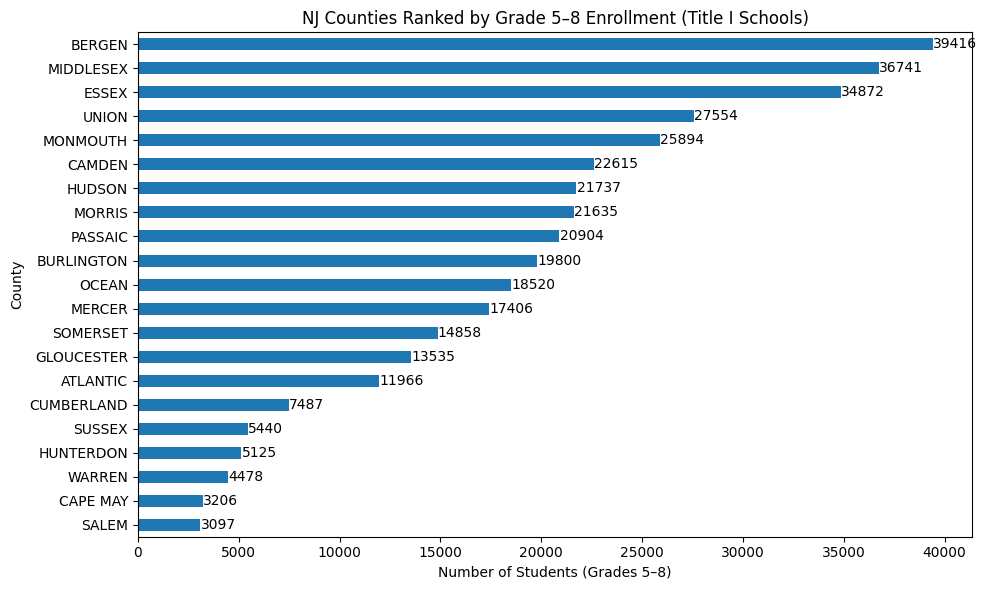

In [23]:
ax = county_totals.plot(
    x="County Name", y="Grades 5-8",
    kind="barh", figsize=(10,6),
    legend=False, title="NJ Counties Ranked by Grade 5–8 Enrollment (Title I Schools)"
)
ax.set_xlabel("Number of Students (Grades 5–8)")
ax.set_ylabel("County")


for i, v in enumerate(county_totals["Grades 5-8"]):
        ax.text(v + 15, i, str(v), va="center")

plt.tight_layout()
plt.show()


In [60]:
school_totals = merged.groupby(
    ["County Name", "District Name", "School Name"]
)[["Fifth Grade","Sixth Grade","Seventh Grade","Eighth Grade"]].sum().reset_index()

# Add Grades 5–8 total
school_totals["Grades 5-8"] = school_totals[["Fifth Grade","Sixth Grade","Seventh Grade","Eighth Grade"]].sum(axis=1)

# Sort within each district
school_totals = school_totals.sort_values(["District Name","Grades 5-8"], ascending=[True,False])


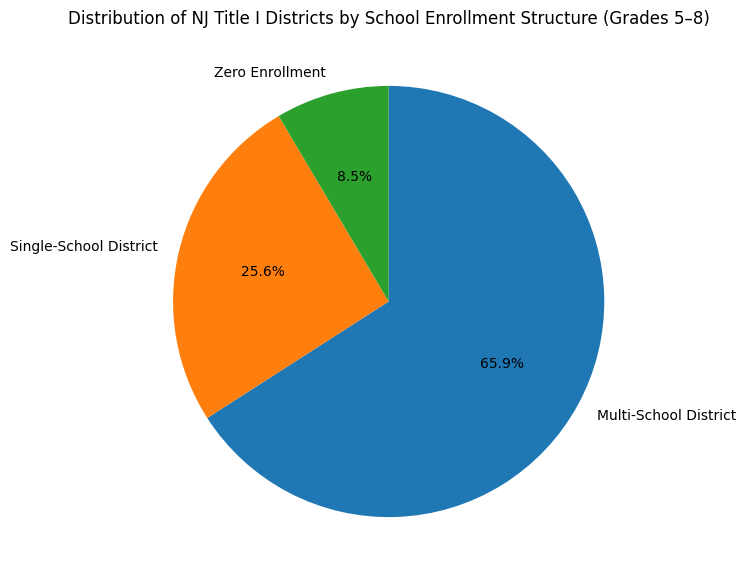

In [67]:
# aggregate district totals
district_summary = school_totals.groupby("District Name")["Grades 5-8"].agg(["sum","count"]).reset_index()

# classify districts
def classify(row):
    if row["sum"] == 0:
        return "Zero Enrollment"
    elif row["count"] == 1:
        return "Single-School District"
    else:
        return "Multi-School District"

district_summary["Category"] = district_summary.apply(classify, axis=1)

# count categories
category_counts = district_summary["Category"].value_counts()

# pie chart
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(
    category_counts, labels=category_counts.index,
    autopct='%1.1f%%', startangle=90, counterclock=False
)
ax.set_title("Distribution of NJ Title I Districts by School Enrollment Structure (Grades 5–8)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Get all districts
districts = school_totals["District Name"].unique()

# Open a multipage PDF
with PdfPages("District_School_Enrollment_5_8.pdf") as pdf:
    for district in districts:
        subset = school_totals[school_totals["District Name"] == district]
        subset = subset.sort_values("Grades 5-8", ascending=True)

        fig, ax = plt.subplots(figsize=(10, 6))
        subset.plot(
            x="School Name", y="Grades 5-8",
            kind="barh", ax=ax, legend=False
        )

        ax.set_title(f"{district} - School Enrollment (Grades 5–8)")
        ax.set_xlabel("Number of Students")
        ax.set_ylabel("School")

        # Add labels to bars
        for i, v in enumerate(subset["Grades 5-8"]):
            ax.text(v + 5, i, str(v), va="center")

        plt.tight_layout()
        pdf.savefig(fig)  # save this figure into PDF
        plt.close(fig)

print("✅ PDF created: District_School_Enrollment_5_8.pdf")
